# Solution using LightFM library
## Imports

In [31]:
from lightfm import LightFM
import numpy as np

from src.seeding import set_seed
from src.config import SEED, PROJECT_ROOT
from src.data.movielens_dataset import MovieLensDataset, AvailableSplits
from src.lightfm_model import LightFMWrapper
from src.train import train
from src.visualize import plot_metrics
from src.data.load import load_ratings, load_movie_data

In [2]:
set_seed(SEED)
K = 20

## Loading the data
I moved all the data loading and preprocessing to the separate script, so it is possible to load the dataset in simple way:

In [7]:
dataset = MovieLensDataset.from_split(AvailableSplits.FIRST, rating_threshold=4)

I want to describe what happens inside this one line:
1. Script loads on of the pre-defined train/test splits from the dataset.
2. Then it loads user and movie features and preprocess them. It seems that LightFM supports mostly categorical features, so I focused on such features: 
    1. Script loads movie features and substitutes actual genre name instead of one-hot encoded one.
    2. Script loads user features and creates age group column.
3. Then a LightFM dataset constructed from the data above. LightFM has a built-in MovieLens dataset, but it lacks user features, so I built my own.

Also, about the `rating_threshold` parameter. It is used to transform rating to the type of interactions (positive or negative). But the model performs worse with any negative interactions (and using appropriate loss for them), so I just do not add interaction to the dataset if it has low rating. It allows to using more loss functions from the library like WARP or BPR, which performs better.

## Training the model

In [8]:
model = LightFM(loss="warp", no_components=256, random_state=SEED)

In [9]:
model_wrapper = LightFMWrapper(model)

In [10]:
metric_report = train(model_wrapper, dataset, epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

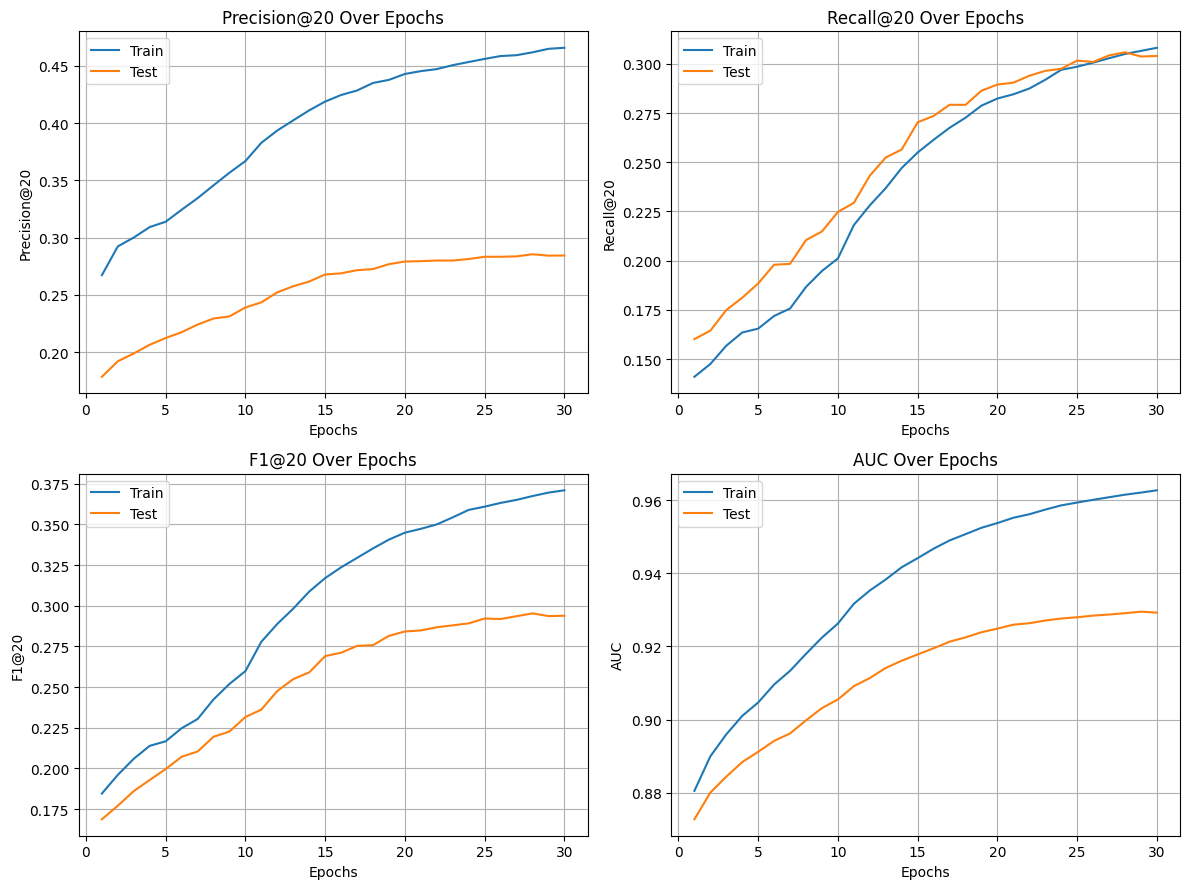

In [11]:
plot_metrics(metric_report)

## Saving the model

There is no built-in way to save the LightFM model, so I am using pickle to do it:

In [13]:
model_wrapper.save(PROJECT_ROOT / "models" / "model.pickle")

## Check what the model actually recommends

In [28]:
all_ratings = load_ratings("u.data")

In [32]:
movie_data = load_movie_data()

In [33]:
all_items = np.arange(1, all_ratings.item_id.max() + 1)

In [81]:
user_id = 3
samples = 10

In [82]:
known_positives = all_ratings[
    (all_ratings.user_id == user_id) & (all_ratings.rating >= 4)
].item_id

In [83]:
len(known_positives)

15

In [84]:
set_seed(SEED)
movie_data[movie_data.item_id.isin(known_positives.sample(samples))][["title", "genre"]]

,title,genre
317,Schindler's List (1993),Drama
320,Mother (1996),Comedy
326,Cop Land (1997),Crime
327,Conspiracy Theory (1997),Action
328,Desperate Measures (1998),Crime
330,"Edge, The (1997)",Adventure
339,Boogie Nights (1997),Drama
341,"Man Who Knew Too Little, The (1997)",Comedy
343,"Apostle, The (1997)",Drama
345,Jackie Brown (1997),Crime


In [85]:
recommendation = model_wrapper.make_recommendation(user_id, all_items, dataset, samples)

In [86]:
movie_data[movie_data.item_id.isin(recommendation)][["title", "genre"]]

,title,genre
126,"Godfather, The (1972)",Action
267,Chasing Amy (1997),Drama
268,"Full Monty, The (1997)",Comedy
270,Starship Troopers (1997),Action
287,Scream (1996),Horror
292,Donnie Brasco (1997),Crime
301,L.A. Confidential (1997),Crime
312,Titanic (1997),Action
326,Cop Land (1997),Crime
345,Jackie Brown (1997),Crime


As we can see, there is some intersections with known positives, and genres seems quite close to the ones that user liked.